# Project Sunset
2020년 과학 탐구 보고서 발표 대회에 사용될 코드입니다.

-----------------------------------------------------------------------------------------

FGSM 공격용 이미지를 생성할 ResNet을 학습시킵니다.
사용할 데이터셋은 MNIST입니다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models

import random
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from IPython.display import clear_output


In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [ ]:
MainModel = models.resnet101(pretrained=True)
SubModel = models.vgg19_bn(pretrained=True)

MainModel.eval()
SubModel.eval()

In [3]:
EPOCHS     = 300
BATCH_SIZE = 128

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./.data',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=BATCH_SIZE, shuffle=True)

In [30]:
def vgg_block(num_convs, in_channels, num_channels):
    layers=[]
    for i in range(num_convs):
        layers+=[nn.Conv2d(in_channels=in_channels, out_channels=num_channels, kernel_size=3, padding=1)]
        in_channels=num_channels
    layers +=[nn.ReLU()]
    layers +=[nn.MaxPool2d(kernel_size=2, stride=2)]
    return nn.Sequential(*layers)


class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.conv_arch=((1,1,64),(1,64,128),(2,128,256),(2,256,512),(2,512,512))
        layers=[]
        for (num_convs,in_channels,num_channels) in self.conv_arch:
            layers+=[vgg_block(num_convs,in_channels,num_channels)]
        self.features=nn.Sequential(*layers)
        self.dense1 = nn.Linear(512*7*7,4096)
        self.drop1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(4096, 4096)
        self.drop2 = nn.Dropout(0.5)
        self.dense3 = nn.Linear(4096, 10)
 
    def forward(self,x):
        x=self.features(x)
        x=x.view(-1,512*7*7)
        x=self.dense3(self.drop2(F.relu(self.dense2(self.drop1(F.relu(self.dense1(x)))))))
        return x

In [31]:
model = VGGNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [32]:
def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

In [33]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        print("{0}번째 학습 - 배치 : {1}".format(epoch, batch_idx))
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        #print(output.data)
        #print(target.data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [34]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    lasttarget=None
    lastdata=None
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            lasttarget=target
            lastdata = data[0]
            
    print(lastdata.size())
    imshow(lastdata)
    
    print("예상 답안 : {0}".format(pred[0].item()))
    print("모범 답안 : {0}".format(lasttarget[0].item()))
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [35]:
def test_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    lasttarget=None
    lastdata=None
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            lasttarget=target
            lastdata = data[0]
            break
            
    print(lastdata.size())
    imshow(lastdata)
    
    print("예상 답안 : {0}".format(pred[0].item()))
    print("모범 답안 : {0}".format(lasttarget[0].item()))
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [36]:
already=1
for epoch in range(already, EPOCHS + 1):
    scheduler.step()
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    clear_output(wait=True)
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

1번째 학습 - 배치 : 0


RuntimeError: Given input size: (512x1x1). Calculated output size: (512x0x0). Output size is too small

torch.Size([1, 28, 28])


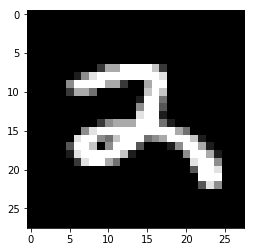

예상 답안 : 2
모범 답안 : 2


(0.001161494255065918, 1.24)

In [55]:
test_model(model, test_loader)

In [ ]:
def save_checkpoint(path, epoch, model, optimizer, scheduler):
    state = {
        'Epoch': epoch,
        'State_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
    }
    torch.save(state, path)
    
def load_checkpoint(path, model, optimitzer, scheduler):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['State_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    epoch = int(checkpoint['Epoch'])
    return model, optimizer, epoch, scheduler
    

In [23]:
save_checkpoint("checkpoints/model_1/checkpoints1.tar", already, model, optimizer, scheduler)

In [56]:
torch.save(model, './model/PreTrained ResNet/preTrainedResNet_mnist.pt')

C:\Users\LHZ\anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\LHZ\anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
img = Image.open('imagenet_samples/corgie.jpg')

img_transforms = transforms.Compose([
    transforms.Resize((32, 32), Image.BICUBIC),
    transforms.ToTensor(),
])

img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

print("이미지 텐서 모양:", img_tensor.size())

In [65]:
def fgsm_attack(image, epsilon, gradient):
    # 기울기값의 원소의 sign 값을 구함
    sign_gradient = gradient.sign()
    # 이미지 각 픽셀의 값을 sign_gradient 방향으로 epsilon 만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    # [0,1] 범위를 벗어나는 값을 조절
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [76]:
for img_tensor, target in test_loader:
    print(target)
    output = model(img_tensor)
    prediction = output.max(1, keepdim=False)[1]
    print("---------------------------------------------------")
    print(prediction)
    prediction_idx = prediction[0].item()
    
    img_tensor.requires_grad_(True)

    output = model(img_tensor)

    loss = F.nll_loss(output, target) 

    model.zero_grad()
    loss.backward()

    gradient = img_tensor.grad.data

    epsilon = 0.03
    perturbed_data = fgsm_attack(img_tensor, 0.1, gradient)
    
    output = model(perturbed_data)
    perturbed_prediction = output.max(1, keepdim=False)[1]
    perturbed_prediction_idx = perturbed_prediction[0].item()
    print("---------------------------------------------------")
    print(perturbed_prediction)
    
    
    break

tensor([8, 7, 7, 9, 0, 3, 0, 9, 8, 2, 5, 2, 1, 7, 3, 7, 0, 4, 2, 1, 6, 6, 3, 7,
        4, 6, 7, 0, 3, 8, 0, 3, 2, 0, 0, 3, 9, 5, 5, 5, 9, 6, 2, 7, 8, 1, 3, 9,
        6, 2, 7, 8, 2, 1, 8, 3, 6, 4, 3, 3, 4, 9, 7, 6, 2, 8, 6, 3, 8, 6, 4, 7,
        4, 7, 4, 3, 3, 7, 1, 1, 1, 4, 5, 2, 5, 5, 7, 1, 9, 5, 7, 5, 6, 2, 6, 0,
        1, 9, 2, 0, 4, 2, 6, 3, 0, 2, 6, 4, 5, 1, 7, 0, 0, 2, 8, 1, 6, 3, 3, 1,
        7, 4, 5, 1, 0, 1, 1, 3])
---------------------------------------------------
tensor([8, 7, 7, 9, 0, 3, 0, 9, 8, 2, 5, 2, 1, 7, 3, 7, 0, 4, 2, 1, 6, 6, 3, 7,
        4, 6, 7, 0, 3, 8, 0, 3, 2, 0, 0, 3, 9, 5, 5, 5, 9, 6, 2, 7, 8, 1, 3, 9,
        6, 2, 2, 8, 2, 1, 8, 3, 6, 4, 5, 3, 4, 9, 7, 6, 2, 8, 6, 3, 8, 1, 4, 7,
        4, 7, 4, 3, 3, 7, 1, 1, 1, 4, 5, 2, 5, 5, 7, 1, 9, 5, 7, 5, 6, 2, 5, 0,
        1, 9, 2, 0, 4, 2, 6, 3, 6, 2, 6, 4, 5, 1, 7, 0, 0, 2, 8, 1, 6, 3, 3, 1,
        7, 4, 5, 1, 0, 1, 1, 3])
---------------------------------------------------
tensor([8, 1, 1, 1, 1, 1, 1, 1

tensor([0, 8, 2, 8, 1, 4, 7, 0, 2, 3, 0, 4, 2, 5, 3, 4, 8, 0, 7, 1, 2, 1, 5, 6,
        6, 9, 5, 5, 4, 9, 0, 1, 4, 9, 2, 6, 5, 3, 0, 2, 2, 5, 8, 2, 1, 8, 7, 5,
        9, 1, 9, 2, 3, 3, 5, 7, 9, 7, 8, 6, 0, 6, 9, 3, 3, 4, 4, 4, 8, 5, 1, 5,
        6, 2, 4, 2, 7, 5, 4, 7, 2, 7, 1, 3, 4, 6, 2, 0, 3, 8, 8, 2, 6, 2, 6, 3,
        5, 0, 4, 7, 7, 5, 7, 4, 3, 7, 1, 5, 4, 6, 7, 9, 1, 9, 6, 3, 3, 5, 6, 5,
        4, 1, 6, 0, 7, 3, 2, 9])
예측된 레이블 번호: 0


예측된 레이블 번호: 0
